In [119]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from itertools import product
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [120]:
def manual_error_rate(df, models=None, proba=False, diag=False):
    features = df['feature']
    labels = df['label']

    arr_len = len(features[0])
    tot_enumerations = 2**arr_len

    permutations = list(product([0, 1], repeat=arr_len))

    results = []
    results_p_1 = []
    results_p_2 = []

    for perm in tqdm(permutations, total=tot_enumerations, desc="Processing permutations"):
        perm_array = np.array(perm)
        count = 0
        error_count = 0

        for feature, label in zip(features, labels):
            if np.array_equal(feature, perm_array):
                count += 1
                if label == 0:
                    error_count += 1
        if count > 0:
          error_rate = (error_count / count)
          results.append([perm, error_rate])
          proba_score = 0
          if proba:
            rf_score = models[0].predict_proba(np.array(perm).reshape(1, -1))[0][0]
            lr_score = models[1].predict_proba(np.array(perm).reshape(1, -1))[0][0]
            results_p_1.append([perm, rf_score])
            results_p_2.append([perm, lr_score])
          if diag: print(f"permutation {perm}: manual error rate is {error_rate*100:.2f}%, proba_score is {proba_score*100:.2f}% appears {count} times")

    if proba: return np.array(results, dtype=object), np.array(results_p_1, dtype=object), np.array(results_p_2, dtype=object)
    else: return np.array(results, dtype=object)


def repopulate_sample(sample, total_manual, model=None):
    tmp = []
    for i, entry in enumerate(total_manual):
        exist = next((row for row in sample if row[0] == entry[0]), None)
        if exist is not None:
            tmp.append([exist[0], exist[1]])
        else:
            if model is not None:
                tmp.append([entry[0], model.predict_proba(np.array(entry[0]).reshape(1, -1))[0][0]])
            else:
                tmp.append([entry[0], 0.5])
    return np.array(tmp, dtype=object)

# Grid Search for Plot Generation

In [121]:
all_features = np.arange(4, 13)
all_sample_sizes = [100, 500, 5000, 10000]


orig_reconstruct = pd.read_csv("rec.csv")
orig_reconstruct["feature"] = orig_reconstruct["feature"].apply(ast.literal_eval)
orig_reconstruct["feature"] = orig_reconstruct["feature"].apply(lambda x: x[-1:] + x[:-1])

#grid search features and sample sizes (brute force all and get array of all combination [ratio, hardness])

results = []
for feature_size in all_features:
    print(f" ---- Testing feature size: {feature_size} ---- ")
    # ---- Load CNN Model Preds ----
    #clip each feature from the right (.ie if each feature has length 14 and i spefcify feature size of 12, remove the right 2 elements from each feature)
    reconstruct = orig_reconstruct.copy()
    reconstruct["feature"] = reconstruct["feature"].apply(lambda x: x[:feature_size])
    print("Calculating Total Manual Error Rates")
    total_manual = manual_error_rate(reconstruct)

    for sample_size in all_sample_sizes:
        print(f"## Sample size: {sample_size}")
        # ---- Sample Set ----
        sample_set = reconstruct.sample(n=sample_size, random_state=42).reset_index(drop=True)

        # ---- Error Pred Models ----
        rf = RandomForestClassifier(random_state=42)
        rf.fit(list(sample_set['feature']), sample_set['label'])
        lr = LogisticRegression(random_state=42)
        lr.fit(list(sample_set['feature']), sample_set['label'])

        # ---- Calculate all 3 Error Rates ----
        print("Calculating Sample Manual and Proba Error Rates")
        manual_sample, rf_sample, lr_sample = manual_error_rate(sample_set, models=[rf, lr], proba=True, diag=False)
        manual_sample = repopulate_sample(manual_sample, total_manual)
        rf_sample = repopulate_sample(rf_sample, total_manual, model=rf)
        lr_sample = repopulate_sample(lr_sample, total_manual, model=lr)

        rf_vs_mt = np.sum((total_manual[:, 1] - rf_sample[:, 1]) ** 2)
        lr_vs_mt = np.sum((total_manual[:, 1] - lr_sample[:, 1]) ** 2)
        ms_vs_mt = np.sum((total_manual[:, 1] - manual_sample[:, 1]) ** 2)

        rf_ratio = rf_vs_mt / ms_vs_mt
        lr_ratio = lr_vs_mt / ms_vs_mt
        hardness = sample_size / (2 ** feature_size)
        print(f"-> RF Ratio: {rf_ratio:.2f}, LR Ratio: {lr_ratio:.2f}, Hardness: {hardness:.2f}")
        results.append([feature_size, sample_size, rf_ratio, lr_ratio, hardness])
    
    print()

 ---- Testing feature size: 4 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 16/16 [00:01<00:00, 10.07it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 16/16 [00:00<00:00, 695.71it/s]


-> RF Ratio: 1.33, LR Ratio: 1.02, Hardness: 6.25
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 16/16 [00:00<00:00, 393.99it/s]


-> RF Ratio: 0.88, LR Ratio: 1.37, Hardness: 31.25
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 16/16 [00:00<00:00, 46.23it/s]


-> RF Ratio: 0.71, LR Ratio: 1.97, Hardness: 312.50
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 16/16 [00:00<00:00, 28.96it/s]


-> RF Ratio: 0.91, LR Ratio: 2.02, Hardness: 625.00

 ---- Testing feature size: 5 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 32/32 [00:03<00:00,  9.90it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 32/32 [00:00<00:00, 729.96it/s]


-> RF Ratio: 1.34, LR Ratio: 0.86, Hardness: 3.12
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 32/32 [00:00<00:00, 390.04it/s]


-> RF Ratio: 1.23, LR Ratio: 1.26, Hardness: 15.62
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 32/32 [00:00<00:00, 60.54it/s]


-> RF Ratio: 0.39, LR Ratio: 1.07, Hardness: 156.25
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 32/32 [00:00<00:00, 35.85it/s]


-> RF Ratio: 0.78, LR Ratio: 1.63, Hardness: 312.50

 ---- Testing feature size: 6 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 64/64 [00:06<00:00,  9.64it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 64/64 [00:00<00:00, 1137.26it/s]


-> RF Ratio: 0.75, LR Ratio: 0.46, Hardness: 1.56
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 64/64 [00:00<00:00, 446.51it/s]

-> RF Ratio: 0.55, LR Ratio: 0.48, Hardness: 7.81
## Sample size: 5000


Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 64/64 [00:00<00:00, 68.17it/s]


-> RF Ratio: 0.33, LR Ratio: 0.67, Hardness: 78.12
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 64/64 [00:01<00:00, 38.01it/s]


-> RF Ratio: 0.42, LR Ratio: 1.06, Hardness: 156.25

 ---- Testing feature size: 7 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 128/128 [00:13<00:00,  9.48it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 128/128 [00:00<00:00, 959.20it/s] 


-> RF Ratio: 0.61, LR Ratio: 0.38, Hardness: 0.78
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 128/128 [00:00<00:00, 497.64it/s]


-> RF Ratio: 0.73, LR Ratio: 0.37, Hardness: 3.91
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 128/128 [00:01<00:00, 73.46it/s]


-> RF Ratio: 0.46, LR Ratio: 0.61, Hardness: 39.06
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 128/128 [00:03<00:00, 39.34it/s]


-> RF Ratio: 0.52, LR Ratio: 0.78, Hardness: 78.12

 ---- Testing feature size: 8 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 256/256 [00:27<00:00,  9.31it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 256/256 [00:00<00:00, 1895.87it/s]


-> RF Ratio: 0.56, LR Ratio: 0.41, Hardness: 0.39
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 256/256 [00:00<00:00, 574.48it/s]


-> RF Ratio: 0.67, LR Ratio: 0.40, Hardness: 1.95
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 256/256 [00:03<00:00, 75.08it/s]


-> RF Ratio: 0.58, LR Ratio: 0.57, Hardness: 19.53
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 256/256 [00:06<00:00, 38.82it/s]


-> RF Ratio: 0.65, LR Ratio: 0.75, Hardness: 39.06

 ---- Testing feature size: 9 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 512/512 [00:56<00:00,  9.13it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 512/512 [00:00<00:00, 2562.46it/s]


-> RF Ratio: 0.49, LR Ratio: 0.39, Hardness: 0.20
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 512/512 [00:00<00:00, 670.42it/s]


-> RF Ratio: 0.54, LR Ratio: 0.34, Hardness: 0.98
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 512/512 [00:06<00:00, 76.66it/s]


-> RF Ratio: 0.54, LR Ratio: 0.44, Hardness: 9.77
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 512/512 [00:12<00:00, 39.84it/s]


-> RF Ratio: 0.57, LR Ratio: 0.56, Hardness: 19.53

 ---- Testing feature size: 10 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 1024/1024 [01:55<00:00,  8.88it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 1024/1024 [00:00<00:00, 2996.20it/s]


-> RF Ratio: 0.52, LR Ratio: 0.43, Hardness: 0.10
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 1024/1024 [00:01<00:00, 728.60it/s]


-> RF Ratio: 0.58, LR Ratio: 0.38, Hardness: 0.49
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 1024/1024 [00:13<00:00, 77.45it/s]


-> RF Ratio: 0.54, LR Ratio: 0.45, Hardness: 4.88
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 1024/1024 [00:26<00:00, 39.22it/s]


-> RF Ratio: 0.60, LR Ratio: 0.56, Hardness: 9.77

 ---- Testing feature size: 11 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 2048/2048 [03:53<00:00,  8.76it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 2048/2048 [00:00<00:00, 3467.37it/s]


-> RF Ratio: 0.53, LR Ratio: 0.48, Hardness: 0.05
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 2048/2048 [00:02<00:00, 749.38it/s]


-> RF Ratio: 0.57, LR Ratio: 0.43, Hardness: 0.24
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 2048/2048 [00:26<00:00, 77.40it/s]


-> RF Ratio: 0.52, LR Ratio: 0.47, Hardness: 2.44
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 2048/2048 [00:52<00:00, 39.26it/s]


-> RF Ratio: 0.58, LR Ratio: 0.61, Hardness: 4.88

 ---- Testing feature size: 12 ---- 
Calculating Total Manual Error Rates


Processing permutations: 100%|██████████| 4096/4096 [05:53<00:00, 11.58it/s]


## Sample size: 100
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 4096/4096 [00:00<00:00, 5498.78it/s]


-> RF Ratio: 0.56, LR Ratio: 0.54, Hardness: 0.02
## Sample size: 500
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 4096/4096 [00:03<00:00, 1151.74it/s]


-> RF Ratio: 0.62, LR Ratio: 0.50, Hardness: 0.12
## Sample size: 5000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 4096/4096 [00:36<00:00, 112.85it/s]


-> RF Ratio: 0.54, LR Ratio: 0.53, Hardness: 1.22
## Sample size: 10000
Calculating Sample Manual and Proba Error Rates


Processing permutations: 100%|██████████| 4096/4096 [01:12<00:00, 56.66it/s]


-> RF Ratio: 0.59, LR Ratio: 0.66, Hardness: 2.44



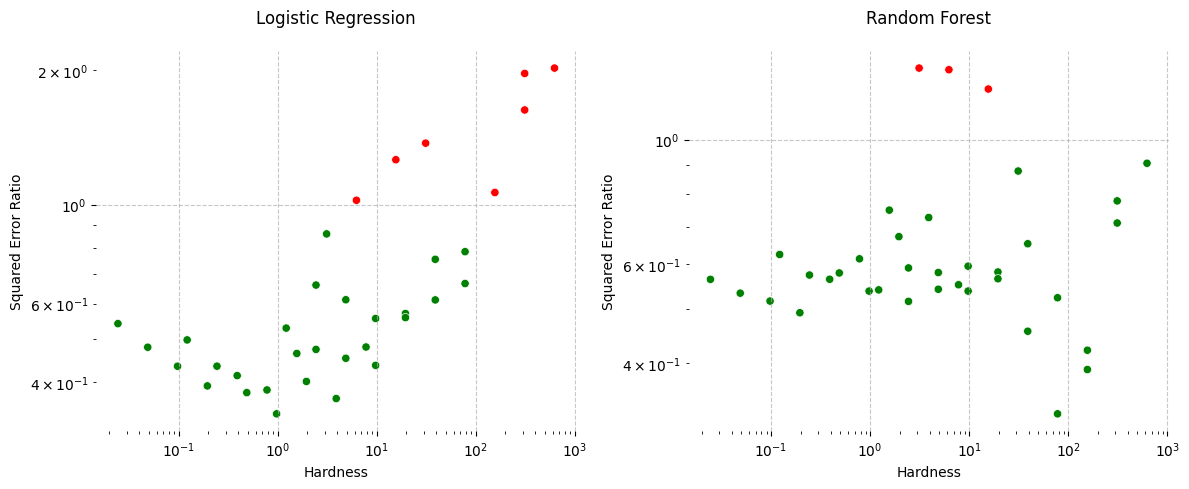

RF: 91.67% are below 1
LR: 77.78% are below 1


In [123]:
np_results = np.array(results)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: using y column index 3
sns.scatterplot(ax=axes[0],
                x=np_results[:, 4],
                y=np_results[:, 3],
                hue=np_results[:, 3] < 1,
                palette={True: 'green', False: 'red'},
                legend=False)
axes[0].set_xlabel('Hardness')
axes[0].set_ylabel('Squared Error Ratio')
axes[0].set_title('Logistic Regression', pad=20)
axes[0].grid(True, linestyle='--', alpha=0.7)
for spine in axes[0].spines.values():
    spine.set_visible(False)
# Apply log scale to both axes for left plot
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Right plot: using y column index 2
sns.scatterplot(ax=axes[1],
                x=np_results[:, 4],
                y=np_results[:, 2],
                hue=np_results[:, 2] < 1,
                palette={True: 'green', False: 'red'},
                legend=False)
axes[1].set_xlabel('Hardness')
axes[1].set_ylabel('Squared Error Ratio')
axes[1].set_title('Random Forest', pad=20)
axes[1].grid(True, linestyle='--', alpha=0.7)
for spine in axes[1].spines.values():
    spine.set_visible(False)
# Apply log scale to both axes for right plot
axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

rf_percentage = np.sum(np_results[:, 2] < 1) / len(np_results)
lr_percentage = np.sum(np_results[:, 3] < 1) / len(np_results)
print(f"RF: {rf_percentage*100:.2f}% are below 1")
print(f"LR: {lr_percentage*100:.2f}% are below 1")


#save results